In [1]:
#Comparing multiclass classifiers

In [2]:
#Evaluating classifier performance

In [3]:
# Load the dataset

%matplotlib inline
import matplotlib.pyplot as pyPlot
import cPickle, gzip, numpy
import numpy as np

f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

train_x = 1*(train_set[0]>0.5)
test_x = 1*(test_set[0]>0.5)
valid_x = 1*(valid_set[0]>0.5)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
#Training a nearest neighbour classifier
from sklearn.neighbors import NearestNeighbors

#model = NearestNeighbors(n_neighbors = 1,n_jobs = 7,leaf_size = 90,metric = 'hamming')
#%time model.fit(train_x)

CPU times: user 20 s, sys: 103 ms, total: 20.1 s
Wall time: 20.1 s


NearestNeighbors(algorithm='auto', leaf_size=90, metric='hamming',
         metric_params=None, n_jobs=7, n_neighbors=1, p=2, radius=1.0)

In [5]:
#Testing the classifier
from scipy.stats import mode
from sklearn import metrics as evalMetrics

#%time testNearestPoints = model.kneighbors(test_x)
#testPred = train_set[1][testNearestPoints[1]]
#testPred = [mode(i)[0][0] for i in testPred]

print evalMetrics.classification_report(test_set[1],testPred)
print evalMetrics.confusion_matrix(test_set[1],testPred)
print evalMetrics.accuracy_score(test_set[1],testPred)

CPU times: user 8min 54s, sys: 1.82 s, total: 8min 56s
Wall time: 1min 21s
             precision    recall  f1-score   support

          0       0.96      0.99      0.98       980
          1       0.94      0.99      0.97      1135
          2       0.98      0.95      0.96      1032
          3       0.93      0.95      0.94      1010
          4       0.97      0.94      0.95       982
          5       0.93      0.94      0.93       892
          6       0.98      0.98      0.98       958
          7       0.94      0.96      0.95      1028
          8       0.98      0.88      0.93       974
          9       0.93      0.93      0.93      1009

avg / total       0.95      0.95      0.95     10000

[[ 972    1    1    0    0    2    3    1    0    0]
 [   0 1129    3    1    0    1    1    0    0    0]
 [  12   13  978    4    2    0    2   17    3    1]
 [   1    4    2  961    1   22    1   10    5    3]
 [   0   13    0    0  927    0    3    3    1   35]
 [   3    1    0   25

In [105]:
#Randomly picking prototypes.
def randomPrototypePerformance(n,repeats=10):
    PRF = []
    Accuracy = []
    microFscore = []
    
    for i in range(repeats):
        randomIndices = np.random.randint(0,len(train_set[1]),n)
        trainRandom_x = train_x[randomIndices,:]
        trainRandom_y = train_set[1][randomIndices]

        modelRandomPrototypes = NearestNeighbors(n_neighbors = 1,n_jobs = 7,leaf_size = 90)
        modelRandomPrototypes.fit(trainRandom_x)

        testNearestPoints = modelRandomPrototypes.kneighbors(test_x)
        testPred = trainRandom_y[testNearestPoints[1]]
        testPred = [mode(i)[0][0] for i in testPred]

        PRF.append(evalMetrics.classification.precision_recall_fscore_support(test_set[1],testPred))
        Accuracy.append(evalMetrics.accuracy_score(test_set[1],testPred))
        microFscore.append(evalMetrics.f1_score(test_set[1],testPred,average = "macro"))
    
    Accuracy = np.array(Accuracy)
    
    Mean_accuracy = np.mean(Accuracy)
    Std_accuracy = np.std(Accuracy)
    
    Mean_microf = np.mean(microFscore)
    Std_microf = np.std(microFscore)
    
    P,R,F,S = zip(*PRF)

    F = np.matrix(F)
    Fstd = np.std(F,axis=0)     
    Fmean = np.mean(F,axis=0)
    
    return (Mean_accuracy,Std_accuracy,Mean_microf,Std_microf)

In [12]:
from collections import defaultdict
from tempfile import mkdtemp
import os.path as path
import heapq
import math

class heapPoint:
    
    def __init__(self,x,y):
        self.value = x
        self.index = y
    
    def __cmp__(self,obj):
        
        if self.value>obj.value:
            return -1
        else:
            return 1
            
class memmappedDistanceMatrix:
    
    def __init__(self,Data,Labels):
        
        self.noItems = Data.shape[0]
        
        #Create hashmap for original indices to compound (label,subIndex) indices
        self.indexLookupTable = dict()
        offset = defaultdict(int)
        
        #Partition data by labels
        self.labelSetIndices = defaultdict(list)
        
        for index,label in enumerate(Labels):
            self.indexLookupTable[index] = (label,offset[label]) 
            offset[label] += 1
            self.labelSetIndices[label].append(index)
        
        #Create the memory mapped distance matrices
        self.distanceMatrices = dict()

        for i in self.labelSetIndices.keys():
            filename = 'Label_'+str(i)+'.dat'
            print "Label " + str(i) + " in progress."
            
            hammingMat = np.dot(train_x[self.labelSetIndices[i],:],np.transpose(1-train_x[self.labelSetIndices[i],:])) + np.dot(1-train_x[self.labelSetIndices[i],:],np.transpose(train_x[self.labelSetIndices[i],:]))
            #memMat = np.memmap(filename, dtype='int16', mode='w+', shape=hammingMat.shape)
            #memMat[:] = hammingMat[:]
            #memMat.flush()
            #del memMat
            #del hammingMat

            self.distanceMatrices[i] = hammingMat

        print "Done"
    
    def __getitem__(self,index):
        
        labelIndex,offset = self.indexLookupTable[index]
        
        #distanceVector = np.array([float("inf")]*self.noItems)
        #distanceVector[self.labelSetIndices[labelIndex]] = self.distanceMatrices[labelIndex][offset,:]
        
        return self.distanceMatrices[labelIndex][offset,:]
    
    def getLabelMatrix(self,label):    
        return self.distanceMatrices[label]

#distMat = memmappedDistanceMatrix(train_x,train_set[1])

Label 0 in progress.
Label 1 in progress.
Label 2 in progress.
Label 3 in progress.
Label 4 in progress.
Label 5 in progress.
Label 6 in progress.
Label 7 in progress.
Label 8 in progress.
Label 9 in progress.
Done


In [40]:
from sklearn.neighbors import NearestNeighbors
from itertools import chain
import copy
import random
import sys

class nnModel:
    """Model class to train NN model by selecting prototypes"""
    
    def __init__(self,Data,Labels,Alpha = 1,Beta = 0.01,distMat = None):
        
        self.Alpha = Alpha
        self.Beta = Beta
        self.Labels = Labels
        self.Data = Data
        
        #Initialize max heap for marginal gains
        self.marginalGainHeap = []
        
        #Create the memory mapped distance matrices
        if distMat == None:
            print "Computing distance matrices"
            self.distanceMatrix = memmappedDistanceMatrix(Data,Labels)  
        else:
            self.distanceMatrix = distMat
            
        #Per class prototype set
        self.prototypeSets = defaultdict(list)
        self.prototypeSize = 0.0

        #Closest distance to every point. Maintained to use in computing delta.
        self.minDistances = np.array([float("inf")]*len(Labels))
        
        #Initialize prototype points in each class
        self.initialPrototypes = []
        
        print "Initializing prototypes"
        
        for label in set(self.Labels):
            prototypeIndex = np.argmin(np.sum(self.distanceMatrix.distanceMatrices[label],axis = 1))
            self.initialPrototypes.append(self.distanceMatrix.labelSetIndices[label][prototypeIndex])
            self.updateSolution(self.distanceMatrix.labelSetIndices[label][prototypeIndex])
        
        #Populate the heap
        print "Populating the heap for optimized lazy function evaluations"
        for index in range(len(self.Labels)):
            heapq.heappush(self.marginalGainHeap,heapPoint(self.computeDelta(index),index))
        
        #Store a copy of the initial heap for retrains
        self.marginalGainHeapInitialValue = copy.deepcopy(self.marginalGainHeap)
        
        print "Initialization Complete"
    
    def updateSolution(self,index):
        
        label = self.Labels[index]
        self.prototypeSets[label].append(index)
        
        self.minDistances[self.distanceMatrix.labelSetIndices[label]] = np.minimum(self.minDistances[self.distanceMatrix.labelSetIndices[label]],self.distanceMatrix[index])
        
        #print self.minDistances
        
        self.prototypeSize += 1
    
    def computeDelta(self,index):
        
        #Should you consider other prototypes for delta calculation. Currently everything considered.
        label = self.Labels[index]
           
        #Compare distance between point ind and all other points in the same set
        deltaFit = self.minDistances[self.distanceMatrix.labelSetIndices[label]] - self.distanceMatrix[index]
        deltaFit = float(sum(deltaFit[(deltaFit>0)]))#/len(self.Labels)
        
        deltaSetExpansionPrior = self.Alpha*math.log(self.prototypeSize / (self.prototypeSize + 1)) - self.Beta
        deltaPrior = 0
        
        for i in set(self.Labels):
            deltaPrior += (label == i) * math.log( float(len(self.prototypeSets[label]) + 1)/len(self.prototypeSets[label]) )
        
        deltaPrior = self.Alpha*float(deltaPrior)#/len(self.Labels)
        
        delta = ( (deltaFit + deltaPrior)/len(self.Labels) ) + deltaSetExpansionPrior
        
        self.deltaLog.append( (deltaFit/len(self.Labels),deltaPrior/len(self.Labels),deltaSetExpansionPrior) )
        return delta
    
    def findNextCandidate(self):
        
        """ Search for next optimal. Uses submodular property to search for the next candidate using lazy evaluations"""
        
        delta = float("-inf")
        optimalIndex = np.nan
        optimatValue = float("-inf")
        numEvals = 0
        while numEvals<len(self.Labels)+1:
            
            upperBoundBestDelta = heapq.heappop(self.marginalGainHeap)
            
            if upperBoundBestDelta.value < 0:
                break
            
            #Compute exact delta for point
            delta = self.computeDelta(upperBoundBestDelta.index)
            
            if delta > self.marginalGainHeap[0].value:
                break
            else:
                #Put point back with updated bound
                heapq.heappush(self.marginalGainHeap,heapPoint(delta,upperBoundBestDelta.index))
            numEvals += 1
        
        #Pick this point
        optimalIndex = self.marginalGainHeap[0].index
        optimalValue = self.marginalGainHeap[0].value
        
        #print "The optimal point was:"+str(optimalValue)
        #print "The number of evaluations was: "+str(numEvals)+"\n"
        return (optimalValue,optimalIndex)
    
    def train(self,cardinalityConstraint = 1000,Alpha = 1, Beta = 0.1):
        
        self.Alpha = Alpha
        self.Beta = Beta
        self.deltaLog = []
        
        #Per class prototype sets
        self.prototypeSets = defaultdict(list)
        self.prototypeSize = 0.0
        
        #Closest distance to every point. Maintained to use in computing delta.
        self.minDistances = np.array([float("inf")]*len(self.Labels))
        
        #Restore inital heap
        self.marginalGainHeap = copy.deepcopy(self.marginalGainHeapInitialValue)
        
        #Restore initial prototypes
        for i in self.initialPrototypes:
            self.updateSolution(i)
        
        #Optimization
        print "Finding Prototypes"
        nextCandidateValue = float("inf")
        nextIndex = np.nan
        optGraph= []
        
        while True:
            nextCandidateValue,nextIndex = self.findNextCandidate()
            optGraph.append(nextCandidateValue)
            
            if nextCandidateValue>0 and self.prototypeSize<cardinalityConstraint:
                self.updateSolution(nextIndex)
            else:
                break
            
            if random.random()<0.3:
                 sys.stdout.write("\r"+str(100*self.prototypeSize/cardinalityConstraint)+"% complete")
        
        print "\nForming the search tree"
        
        self.kdTreePrototypes = NearestNeighbors(n_neighbors = 1,n_jobs = 7,leaf_size = 90,metric = 'hamming')
        
        self.allPrototypes = []
        for i in self.prototypeSets.keys():
            self.allPrototypes += self.prototypeSets[i]
        
        self.allPrototypes = np.array(self.allPrototypes)
        
        self.kdTreePrototypes.fit(self.Data[self.allPrototypes,:])
        
        print "Training done"
        
        return self.deltaLog
    
    def predict(self,testData):
        
        testNearestPoints = self.kdTreePrototypes.kneighbors(testData)
        testNearestIndices = np.array(testNearestPoints[1])
        testPred = self.Labels[self.allPrototypes[testNearestIndices]]
        testPred = [mode(i)[0][0] for i in testPred]
        
        return testPred
        

#%time model = nnModel(train_x,train_set[1],Alpha = 1,Beta = 0.1,distMat = distMat)

Initializing prototypes
Populating the heap for optimized lazy function evaluations
Initialization Complete
CPU times: user 3min 45s, sys: 437 ms, total: 3min 45s
Wall time: 3min 46s


In [49]:
#from sklearn.externals import joblib
#modelCopy = copy.deepcopy(model)
#joblib.dump(model,'nnPrototypeSelectionModel.pkl')
#model = joblib.load('nnPrototypeSelectionModel.pkl')
#print "Model saved"
model = joblib.load('nnPrototypeSelectionModel.pkl') 

Model saved


In [114]:
#Testing on 500 points selection

from scipy import stats
z_critical = stats.norm.ppf(q = 0.975)

nrandomsamples = 10
nprototypesList = [50,100,200,500,1000,5000,10000]

greedyPerfFscore = []
greedyPerfAccuracy = []
randomPerfSamples = []

for nprototypes in nprototypesList:
    optimgraph = model.train(nprototypes,5,0)
    print model.prototypeSize
    testPred = model.predict(test_x)

    greedyPerfFscore.append(evalMetrics.classification.f1_score(test_set[1],testPred,average='macro'))
    greedyPerfAccuracy.append(evalMetrics.accuracy_score(test_set[1],testPred))

    randomPerfSamples.append(randomPrototypePerformance(nprototypes,nrandomsamples))
    

Mean_accuracy,Std_accuracy,Mean_microf,Std_microf = zip(*randomPerfSamples)

Finding Prototypes
90.0% complete
Forming the search tree
Training done
50.0
Finding Prototypes
96.0% complete
Forming the search tree
Training done
100.0
Finding Prototypes
96.0% complete
Forming the search tree
Training done
200.0
Finding Prototypes
98.2% complete
Forming the search tree
Training done
500.0
Finding Prototypes
99.9% complete
Forming the search tree
Training done
1000.0
Finding Prototypes
100.0% complete
Forming the search tree
Training done
5000.0
Finding Prototypes
50.67% complete
Forming the search tree
Training done
5070.0


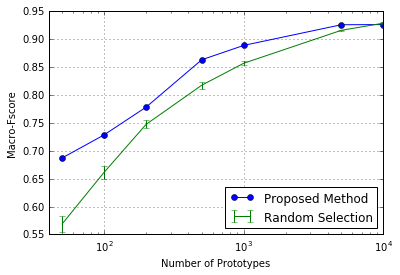

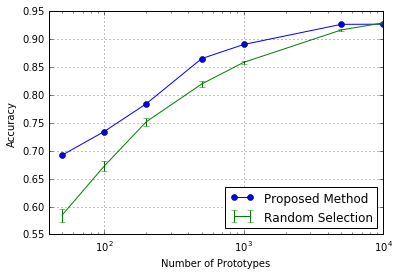

In [139]:
#Plot results

SerrMargin = z_critical*np.array(Std_microf)/math.sqrt(nrandomsamples)
plt.plot(nprototypesList,greedyPerfFscore,marker = 'o',label = 'Proposed Method')
plt.errorbar(nprototypesList,Mean_microf,SerrMargin,label = 'Random Selection')
plt.xlim(min(nprototypesList)-10,max(nprototypesList)+10)
#plt.title(" Comparison")
plt.xscale('log')
plt.xlabel('Number of Prototypes')
plt.ylabel('Macro-Fscore')
plt.grid()
plt.legend(loc = 4)
plt.savefig('FscoreComparison.pdf')
plt.show()

SerrMargin = z_critical*np.array(Std_accuracy)/math.sqrt(nrandomsamples)
plt.plot(nprototypesList,greedyPerfAccuracy,marker = 'o',label = 'Proposed Method')
plt.errorbar(nprototypesList,Mean_accuracy,SerrMargin,label = 'Random Selection')
plt.xlim(min(nprototypesList)-10,max(nprototypesList)+10)
#plt.title("Accuracy Comparison")
plt.xscale('log')
plt.xlabel('Number of Prototypes')
plt.ylabel("Accuracy")
plt.grid()
plt.legend(loc=4)
plt.savefig('AccuracyComparison.pdf')
plt.show()

In [117]:
print Mean_accuracy
print Mean_microf
print greedyPerfFscore
print greedyPerfAccuracy

(0.58467000000000002, 0.67232999999999998, 0.75182999999999989, 0.81969999999999987, 0.85848999999999998, 0.91653000000000007, 0.92920999999999998)
(0.568831235091939, 0.6614890628159672, 0.74740735832087124, 0.81743640261382622, 0.8568514810681378, 0.91586238296711264, 0.92866554231886533)
[0.68709584200444207, 0.72851602385688119, 0.77827217960746498, 0.86306209111042931, 0.88883720058493942, 0.92584429350575326, 0.92617526094646863]
[0.69220000000000004, 0.73440000000000005, 0.78410000000000002, 0.86519999999999997, 0.89049999999999996, 0.92659999999999998, 0.92689999999999995]
